In [2]:
import jax
from jax import numpy as jnp

In [3]:
key = jax.random.PRNGKey(1024)
mat = jax.random.normal(key, shape=(150, 100), dtype='float32')
batch_x = jax.random.normal(key, shape=(20, 100), dtype='float32')

2022-06-14 09:16:08.957780: W external/org_tensorflow/tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-14 09:16:08.957802: W external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)


In [8]:
def batch_dot(batch_x, mat):
    return jnp.stack([jnp.dot(x, mat.T) for x in batch_x])


%timeit batch_dot(batch_x, mat).block_until_ready()

2.2 ms ± 18.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [9]:
def normal_dot(batch_x, mat):
    return jnp.dot(batch_x, mat.T)


%timeit normal_dot(batch_x, mat).block_until_ready()

47.3 µs ± 941 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [18]:
%timeit jax.vmap(batch_dot, in_axes=(0, None))(batch_x, mat)

125 ms ± 1.38 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [34]:
jax.vmap(batch_dot, in_axes=(0, 1))(batch_x, mat).shape

ValueError: vmap got inconsistent sizes for array axes to be mapped:
arg 0 has shape (20, 100) and axis 0 is to be mapped
arg 1 has shape (150, 100) and axis 1 is to be mapped
so
arg 0 has an axis to be mapped of size 20
arg 1 has an axis to be mapped of size 100

In [58]:
@jax.jit
def test_jit(x, y):
    print(f"x = {x}")
    print(f"y = {y}")
    result = jnp.dot(x, y)
    print(f"result = {result}")
    return result

%timeit test_jit(jax.random.normal(key, shape=(10, 10)), jax.random.normal(key, shape=(10, 1))).block_until_ready()
%timeit test_jit(jax.random.normal(key, shape=(10, 10)), jax.random.normal(key, shape=(10, 1))).block_until_ready()
# jax.make_jaxpr(test_jit)(1, 1)
# res, res2

x = Traced<ShapedArray(float32[10,10])>with<DynamicJaxprTrace(level=0/1)>
y = Traced<ShapedArray(float32[10,1])>with<DynamicJaxprTrace(level=0/1)>
result = Traced<ShapedArray(float32[10,1])>with<DynamicJaxprTrace(level=0/1)>
22.7 µs ± 90.4 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
22.9 µs ± 178 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [59]:
def test_jit(x, y):
    result = jnp.dot(x, y)
    return result
jax.make_jaxpr(test_jit)(jax.random.normal(key, shape=(10, 10)), jax.random.normal(key, shape=(10, 1)))

{ lambda ; a:f32[10,10] b:f32[10,1]. let
    c:f32[10,1] = dot_general[
      dimension_numbers=(((1,), (0,)), ((), ()))
      precision=None
      preferred_element_type=None
    ] a b
  in (c,) }

In [67]:
jnp.array([[1, 2], [3, 4]]).prod(0)

# 1, 2   1, 2     7, 10
# 3, 4   3, 4  =  15,22

DeviceArray([3, 8], dtype=int32)

In [78]:
def f(x):
    return x.reshape(jnp.array(x.shape).prod())
x = jnp.zeros((2, 3))
print(f(x))
jit_x = jax.jit(f)
jit_x(x)


[0. 0. 0. 0. 0. 0.]


TypeError: Shapes must be 1D sequences of concrete values of integer type, got [Traced<ShapedArray(int32[])>with<DynamicJaxprTrace(level=0/1)>].
If using `jit`, try using `static_argnums` or applying `jit` to smaller subfunctions.

In [82]:
key = jax.random.PRNGKey(1024)
key2 = jax.random.PRNGKey(1024)
key3 = jax.random.PRNGKey(1024)
key, key2, key3

(DeviceArray([   0, 1024], dtype=uint32),
 DeviceArray([   0, 1024], dtype=uint32),
 DeviceArray([   0, 1024], dtype=uint32))

In [83]:
jax.random.normal(key, shape=(2,)), jax.random.normal(key, shape=(2,)), jax.random.normal(key, shape=(2,))

(DeviceArray([ 0.9467659, -0.7003688], dtype=float32),
 DeviceArray([ 0.9467659, -0.7003688], dtype=float32),
 DeviceArray([ 0.9467659, -0.7003688], dtype=float32))

In [87]:
key4, key5 = jax.random.split(key, 2)

In [88]:
key4, key5

(DeviceArray([ 596893660, 2955029104], dtype=uint32),
 DeviceArray([4120848430, 3735277591], dtype=uint32))

In [91]:
jax.random.split(jnp.array([1, 2], dtype='uint32'))

DeviceArray([[4128513521, 3192206206],
             [2345921600, 3057534555]], dtype=uint32)

In [103]:
@jax.jit
def relu(x):
    return jnp.where(x > 0, x, 0)

grad_relu = jax.jit(jax.grad(relu))
relu(10.), grad_relu(10.), relu(-1.), grad_relu(-1.)

(DeviceArray(10., dtype=float32, weak_type=True),
 DeviceArray(1., dtype=float32, weak_type=True),
 DeviceArray(0., dtype=float32, weak_type=True),
 DeviceArray(0., dtype=float32, weak_type=True))

In [124]:
def f(x):
    return x + 2

jax.grad(f)(jnp.asarray([1,2], dtype='float32'))

TypeError: Gradient only defined for scalar-output functions. Output had shape: (2,).

In [123]:
w = jax.random.normal(key, shape=(4,))
def sse(x, y):
    y_hat = jnp.dot(x, w)
    return jnp.sum((y_hat - y) ** 2)

grad_sse = jax.grad(sse)
grad_sse(jax.random.normal(key2, shape=(2, 4)), jax.random.normal(key3, shape=(2,)))

DeviceArray([[ 0.52911216, -0.23908976, -0.85075116, -0.54860884],
             [-0.90879905,  0.41065875,  1.4612437 ,  0.9422863 ]],            dtype=float32)

In [126]:
grad_sse = jax.value_and_grad(sse)
grad_sse(jax.random.normal(key2, shape=(2, 4)), jax.random.normal(key3, shape=(2,)))

(DeviceArray(0.23487574, dtype=float32),
 DeviceArray([[ 0.52911216, -0.23908976, -0.85075116, -0.54860884],
              [-0.90879905,  0.41065875,  1.4612437 ,  0.9422863 ]],            dtype=float32))

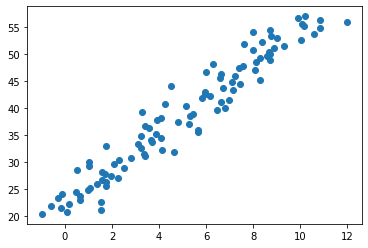

In [195]:
x = jnp.linspace(0, 10, num=100)
y = x * 3.66 + 20.43
x = x + jax.random.normal(key5, shape=(100,))
from matplotlib import pyplot as plt
plt.scatter(x, y)

In [196]:
x = x[:, None]
x = jnp.concatenate((x, jnp.ones((x.shape[0], 1))), axis=1)

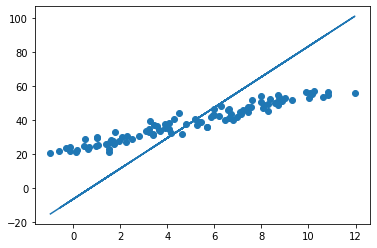

In [198]:
w = jax.random.normal(key, shape=(x.shape[1], 1))
n_loop = 100
lr = 1e-1

def net(x, w):
    return jnp.dot(x, w)

def loss_fn(x, w, y):
    y_hat = net(x, w)
    return jnp.mean((y_hat - y) ** 2)

loss_and_grad = jax.jit(jax.value_and_grad(loss_fn))

for i in range(n_loop):
    # y_hat = net(x, w)
    loss, grads = loss_and_grad(x, w, y)
    w = w - lr * jnp.mean(grads, axis=0)[:, None]
    
y_hat = net(x, w)
plt.scatter(x[:, 0], y)
plt.plot(x[:, 0], y_hat)

In [201]:
net(jnp.array([0, 1], dtype='float32'), w)

DeviceArray([-6.652802], dtype=float32)

In [208]:
def ls(x, y):
    return jnp.dot(jnp.linalg.inv(jnp.dot(x.T, x)), jnp.dot(x.T, y))
ls_w = ls(x, y)  # 

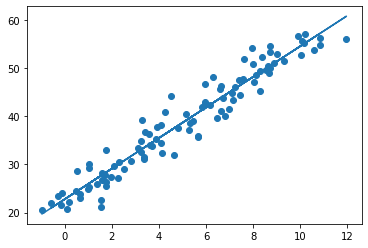

In [210]:
y_hat = net(x, ls_w)
plt.scatter(x[:, 0], y)
plt.plot(x[:, 0], y_hat)